Load data

In [1]:
import random
import torch
from torchvision import datasets

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


def getMNIST(batch_size:int):

    mnist_train = datasets.MNIST(
        "../data", 
        train=True, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    mnist_test = datasets.MNIST(
        "../data", 
        train=False, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, test_loader

def getFashionMNIST(batch_size:int):

    mnist_train = datasets.FashionMNIST(
        "../data", 
        train=True, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    mnist_test = datasets.FashionMNIST(
        "../data", 
        train=False, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, test_loader

In [2]:
#getModel 
import torch
from torch import nn
from torch.nn import functional as F

class MLP(nn.Module):
    """
    basic multi-layer perceptron
    """
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.flat = Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = self.flat(input)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


In [3]:
#gettrainer 
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import torch.utils.data


def var2device(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

def one_epoch_baseline(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr = 1e-3):
    model.train()
    epoch_loss = 0
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        input = input.squeeze(1) 
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def test(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = var2device(input), var2device(target)
        input = input.squeeze(1)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)

def elastic_weight_consolidation_training(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training using the 
    elastic_weight_consolidation method
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_baseline(model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 


In [4]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# task A training and test set
train_loader_mnist, test_loader_mnist = getMNIST(batch_size=32)

# task B training and test set
train_loader_fashion, test_loader_fashion = getFashionMNIST(batch_size=32)


/home/pkpc/anaconda3/envs/fs_env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor(6)
torch.Size([28, 28])


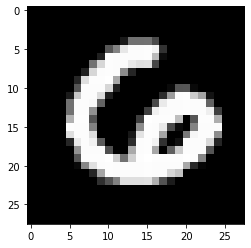

In [6]:
input_image, target_label = next(iter(train_loader_mnist))

print(target_label[0])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

Bag
torch.Size([28, 28])


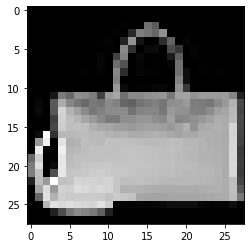

In [7]:
input_image, target_label = next(iter(train_loader_fashion))

fashion_key = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

print(fashion_key[int(target_label[0].detach().cpu().numpy())])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)


traning the model with out EWC on MNIST and then retain on Fashion-MNIST and then test on MNIST

In [8]:
import math
import random

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm

#from contlearn.getmodels import MLP
#from contlearn.gettrainer import one_epoch_baseline, test, var2device

%load_ext autoreload
%autoreload 2
%matplotlib inline

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("you have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print(device)
else:
    use_cuda = False
    print('no GPUs detected')
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
you are using PyTorch version  1.9.0
you have 1 GPUs
cuda:0


In [9]:
# initialize a new model

model = MLP(hidden_size=256)

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# push an image through it

input_image, target_label = next(iter(train_loader_fashion))

input_image = var2device(input_image).squeeze(1)

print(input_image.shape)

output = model(input_image)

print(output.shape)

torch.Size([32, 28, 28])
torch.Size([32, 10])


In [10]:
def baseline_training(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_baseline(model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model

In [11]:
# set seeds for reproducibility and train the model using the training loop called
# baseline_training
#import IProgress 
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 25,
    train_loader = train_loader_mnist,
    test_loader = test_loader_mnist,
)

# save the trained model
model = model.cpu()
torch.save(model, "files/basemodel.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

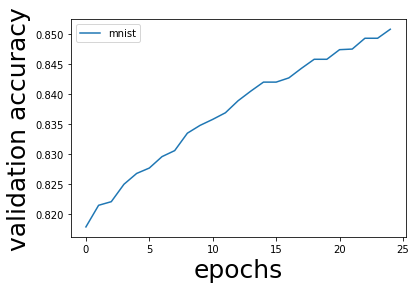

In [19]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='mnist')
plt.legend()
plt.show()

In [12]:
# you can use this to load the model instead of training it from scratch like above 

model = torch.load("files/basemodel.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
print('mnist accuracy', test(model,test_loader_mnist))
print('fashion accuracy', test(model,test_loader_fashion))

mnist accuracy tensor(0.8508, device='cuda:0')
fashion accuracy tensor(0.1556, device='cuda:0')


In [13]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = baseline_training(
    model,
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)
# save the trained model
model = model.cpu()
torch.save(model, "files/basemodel_train_on_fashion.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

In [14]:

# you can use this to load the model instead of training it from scratch like above 

model = torch.load("files/basemodel_train_on_fashion.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
print('mnist accuracy', test(model,test_loader_mnist))
print('fashion accuracy', test(model,test_loader_fashion))

mnist accuracy tensor(0.2795, device='cuda:0')
fashion accuracy tensor(0.5377, device='cuda:0')


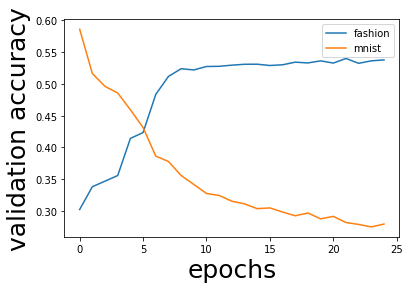

In [15]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.legend()
plt.show()

EWC apply 

In [16]:
# instead of revisiting every old MNIST example to build our Fisher Information Matrix
# use num_samples of them to calculate a approximate of the matrix

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

num_batches = 16

old_tasks = []

for sample in range(num_batches):
    input_batch, target_batch = next(iter(train_loader_mnist))
    for image in input_batch:
        old_tasks.append(image)
    
print("num_samples", len(old_tasks))

num_samples 512


In [17]:
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import torch.utils.data


%load_ext autoreload
%autoreload 2
%matplotlib inline


# Uncomment one of the two below lines of code that instantiates a model
### birth a new randomly initiated model ###

# model = MLP(hidden_size=256)

### load a model previously trained on one task, task A ###

model = torch.load("files/basemodel.pth")

#####


if torch.cuda.is_available() and use_cuda:
    model.cuda()    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
acc = test(model,test_loader_mnist)
print("accuracy on mnist test set", acc.item())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
accuracy on mnist test set 0.8507999777793884


In [18]:
class EWC(object):
    
    """
    Class to calculate the Fisher Information Matrix
    used in the Elastic Weight Consolidation portion
    of the loss function
    """
    
    def __init__(self, model: nn.Module, dataset: list):

        self.model = model #pretrained model
        self.dataset = dataset #samples from the old task or tasks
        
        # n is the string name of the parameter matrix p, aka theta, aka weights
        # in self.params we reference all of those weights that are open to
        # being updated by the gradient
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # make a copy of the old weights, ie theta_A,star, ie 𝜃∗A, in the loss equation
        # we need this to calculate (𝜃 - 𝜃∗A)^2 because self.params will be changing 
        # upon every backward pass and parameter update by the optimizer
        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = var2device(p.data)
        
        # calculate the fisher information matrix 
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        
        # save a copy of the zero'd out version of
        # each layer's parameters of the same shape
        # to precision_matrices[n]
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = var2device(p.data)

        # we need the model to calculate the gradient but
        # we have no intention in this step to actually update the model
        # that will have to wait for the combining of this EWC loss term
        # with the new task's loss term
        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            input = input.squeeze(1)
            input = var2device(input)
            output = self.model(input).view(1, -1)
            #print(output.shape)
            label = output.max(1)[1].view(-1)
            #print(label.shape)
            # calculate loss and backprop
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss
    
# place the model pretrained on mnist, but not fashion-mnist, along with some mnist examples
# into the Elastic Weight Consolidation object to perform EWC related tasks like calculating the
# Fisher Matrix
ewc = EWC(model, old_tasks)


In [19]:
precision_matrices = {}
for n, p in deepcopy(ewc.params).items():
    
    print("name of this layer's weights:", n)
    p.data.zero_()
    precision_matrices[n] = var2device(p.data)
    print("shape of this matrix W", precision_matrices[n].shape)
    #print(precision_matrices[n])
    print("norm of the matrix",torch.norm(precision_matrices[n]).item())
    break


name of this layer's weights: fc1.weight
shape of this matrix W torch.Size([256, 784])
norm of the matrix 0.0


input.shape torch.Size([1, 28, 28])
[0.0, 0.0, 1.9054186, 0.0, 2.121875, 0.0, 6.532875, 0.0, 0.0, 0.0]
predicted number tensor([6], device='cuda:0')
loss 0.031601645052433014


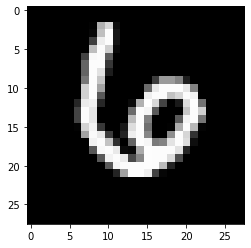

In [20]:
ewc.model.eval()
for input in ewc.dataset:
    ewc.model.zero_grad()
    # no need for the channel dim, these are greyscale, not color rgb images
    # bs,1,h,w -> bs,h,w
    input = input.squeeze(1)
    input = var2device(input)
    output = ewc.model(input).view(1, -1)
    label = output.max(1)[1].view(-1)
    loss = F.nll_loss(F.log_softmax(output, dim=1), label)
    loss.backward()    
    break

print("input.shape", input.shape)
img = Image.fromarray(input[0].detach().cpu().numpy()*255)
plt.imshow(img)

print(list(output.detach().cpu().numpy()[0]))
print("predicted number",label)
print("loss",loss.item())


In [21]:
for n, p in ewc.params.items():
    print("name of this layer's weights:", n)
    print("shape of p.grad.data", p.grad.data.shape)
    print("shape of p.grad.data ** 2", (p.grad.data ** 2).shape)
    precision_matrices[n].data += p.grad.data ** 2 / len(ewc.dataset)
    #print(precision_matrices[n])
    print("norm of the matrix",torch.norm(precision_matrices[n]).item())
    break

name of this layer's weights: fc1.weight
shape of p.grad.data torch.Size([256, 784])
shape of p.grad.data ** 2 torch.Size([256, 784])
norm of the matrix 1.626071571081411e-05


In [22]:
# since the parameters have not changed yet, we expect (𝜃 - 𝜃∗)2 to be zero throughout
ewc.penalty(model)


tensor(0., device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
# verify that the model you are about to retrain is indeed pretrained
acc = test(model,test_loader_mnist)
print("accuracy on mnist test set", acc.item())


accuracy on mnist test set 0.8507999777793884


In [24]:
def one_epoch_ewc(
    ewc: EWC, 
    importance: float,
    model: nn.Module, 
    data_loader: torch.utils.data.DataLoader, 
    lr = 1e-3,
):
    model.train()
    epoch_loss = 0
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        input = input.squeeze(1) 
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def ewc_training(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_ewc(ewc,importance, model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 

In [25]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 1000,
    model = model,
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)
# save the trained model
model = model.cpu()
torch.save(model, "files/basemodel_ewc_train_on_fashion.pth")


  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:

# you can use this to load the model instead of training it from scratch like above 

model = torch.load("files/basemodel_ewc_train_on_fashion.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# tensor(0.8238, device='cuda:0') means that the test set accuracy was 82.4%
# compared to a baseline accuracy of 10% if the model is choosing randomly
print('mnist accuracy', test(model,test_loader_mnist))
print('fashion accuracy', test(model,test_loader_fashion))

mnist accuracy tensor(0.8055, device='cuda:0')
fashion accuracy tensor(0.5402, device='cuda:0')


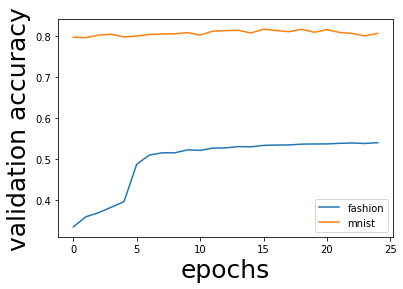

In [27]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.legend()
plt.show()


In [ ]:
# save the trained model
model = model.cpu()
torch.save(model, "files/ewcmodel.pth")